In [1]:
%pylab inline
import pandas as pd
import numpy as np
import pickle,itertools,sys,pdb
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import graphviz
from ultron.factor.genetic.accumulators import mutated_pool, cross_pool
from ultron.sentry.Analysis.SecurityValueHolders import SecurityValueHolder
from ultron.sentry.Analysis.SecurityValueHolders import SecurityCombinedValueHolder

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ultron.sentry.Analysis.SecurityValueHolders import SecurityLatestValueHolder
from ultron.sentry.Analysis.SecurityValueHolders import SecurityCurrentValueHolder
from ultron.sentry.Analysis.TechnicalAnalysis.StatelessTechnicalAnalysers import SecurityDiffValueHolder
from ultron.sentry.Analysis.TechnicalAnalysis.StatelessTechnicalAnalysers import SecuritySignValueHolder
from ultron.sentry.Analysis.TechnicalAnalysis.StatelessTechnicalAnalysers import SecurityExpValueHolder
from ultron.sentry.Analysis.TechnicalAnalysis.StatelessTechnicalAnalysers import SecurityLogValueHolder
from ultron.sentry.Analysis.TechnicalAnalysis.StatelessTechnicalAnalysers import SecuritySqrtValueHolder
from ultron.sentry.Analysis.TechnicalAnalysis.StatelessTechnicalAnalysers import SecurityAbsValueHolder
from ultron.sentry.Analysis.TechnicalAnalysis.StatelessTechnicalAnalysers import SecurityNormInvValueHolder
from ultron.sentry.Analysis.TechnicalAnalysis.StatelessTechnicalAnalysers import SecurityCeilValueHolder
from ultron.sentry.Analysis.TechnicalAnalysis.StatelessTechnicalAnalysers import SecurityFloorValueHolder
from ultron.sentry.Analysis.TechnicalAnalysis.StatelessTechnicalAnalysers import SecurityRoundValueHolder
from ultron.sentry.Analysis.TechnicalAnalysis.StatelessTechnicalAnalysers import SecuritySigmoidValueHolder
from ultron.sentry.Analysis.TechnicalAnalysis.StatelessTechnicalAnalysers import SecurityTanhValueHolder
from ultron.sentry.Analysis.CrossSectionValueHolders import CSRankedSecurityValueHolder
from ultron.sentry.Analysis.CrossSectionValueHolders import CSZScoreSecurityValueHolder
from ultron.sentry.Analysis.CrossSectionValueHolders import CSPercentileSecurityValueHolder


from ultron.sentry.Analysis.CrossSectionValueHolders import CSResidueSecurityValueHolder
from ultron.sentry.Analysis.SecurityValueHolders import SecurityAddedValueHolder
from ultron.sentry.Analysis.SecurityValueHolders import SecuritySubbedValueHolder
from ultron.sentry.Analysis.SecurityValueHolders import SecurityMultipliedValueHolder
from ultron.sentry.Analysis.SecurityValueHolders import SecurityDividedValueHolder
from ultron.sentry.Analysis.SecurityValueHolders import SecurityLtOperatorValueHolder
from ultron.sentry.Analysis.SecurityValueHolders import SecurityLeOperatorValueHolder
from ultron.sentry.Analysis.SecurityValueHolders import SecurityGtOperatorValueHolder
from ultron.sentry.Analysis.SecurityValueHolders import SecurityGeOperatorValueHolder
from ultron.sentry.Analysis.SecurityValueHolders import SecurityEqOperatorValueHolder
from ultron.sentry.Analysis.SecurityValueHolders import SecurityNeOperatorValueHolder
from ultron.sentry.Analysis.SecurityValueHolders import SecurityAndOperatorValueHolder
from ultron.sentry.Analysis.SecurityValueHolders import SecurityOrOperatorValueHolder


In [3]:
# 读取算子
mutated_list = list(mutated_pool.values())
cross_list =  list(cross_pool.values())

In [4]:
with open('factor_data.pkl','rb') as file2:
    total_data = pickle.load(file2)

In [5]:
facotr_sets = [i for i in list(set(total_data.columns)) if i not in ['trade_date','code','ret']]

In [6]:
#合并函数
mutated_sets = [{'activy':1,'function': f} for f in mutated_list]
cross_sets = [{'activy':2,'function': f} for f in cross_list]
function_sets = mutated_sets + cross_sets

In [7]:
def calcu_program(max_depth=4):
    n_features = 2
    function_obj = function_sets[np.random.randint(0,len(function_sets)-1)] # 随机选择函数
    program = [function_obj]
    terminal_stack = [function_obj['activy']]
    while terminal_stack:
        depth = len(terminal_stack)
        choice = n_features + len(function_sets)
        choice = np.random.randint(0,choice)
        if depth < max_depth and choice <= len(function_sets):
            function_obj = function_sets[np.random.randint(0,len(function_sets)-1)] 
            program.append(function_obj)
            terminal_stack.append(function_obj['activy'])
        else:
            factor = facotr_sets[np.random.randint(0,len(facotr_sets)-1)]
            program.append(factor)
            terminal_stack[-1] -= 1
            while terminal_stack[-1] == 0:
                terminal_stack.pop()
                if not terminal_stack:
                    return program
                terminal_stack[-1] -= 1

In [8]:
def draw_program(program):
    fade_nodes = None
    terminals = []
    if fade_nodes is None:
        fade_nodes = []
    output = 'digraph program {\nnode [style=filled]\n'
    for i, node in enumerate(program):
        fill = '#cecece'
        if node in function_sets:
            if i not in fade_nodes:
                fill = '#2a5caa'
            terminals.append([node['activy'], i])
            output += ('%d [label="%s", fillcolor="%s"] ;\n'
                           % (i, node['function'].__name__, fill))
        else:
            if i not in fade_nodes:
                fill = '#60a6f6'
            if node in facotr_sets:
                feature_name = node
            else:
                feature_name = 'X%s' % node
            output += ('%d [label="%s", fillcolor="%s"] ;\n'
                               % (i, feature_name, fill))
        
            if i == 0 :
                output += '}'
                return output
            terminals[-1][0] -= 1
            terminals[-1].append(i)
            while terminals[-1][0] == 0:
                output += '%d -> %d ;\n' % (terminals[-1][1],
                                                terminals[-1][-1])
                terminals[-1].pop()
                if len(terminals[-1]) == 2:
                    parent = terminals[-1][-1]
                    terminals.pop()
                    if not terminals:
                        output += '}'
                        return output
                    terminals[-1].append(parent)
                    terminals[-1][0] -= 1

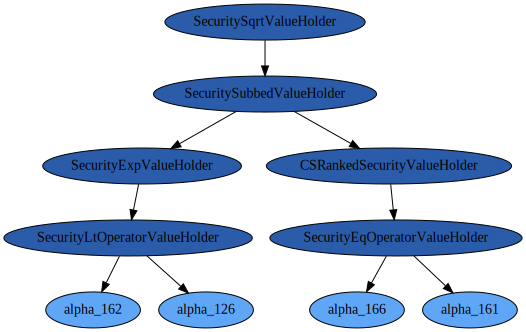

In [9]:
graph = graphviz.Source(draw_program(calcu_program()))
graph

In [10]:
graph.render('test-table3.gv', view=True)

'test-table3.gv.pdf'

# 繁衍计算

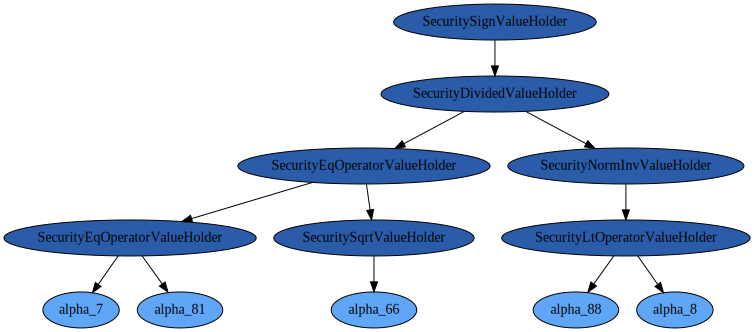

In [13]:
program = calcu_program()
graphviz.Source(draw_program(program))

In [12]:
def get_subtree(program):
    probs = np.array([0.9 if node in function_sets else 0.1 for node in program])
    probs = np.cumsum(probs / probs.sum())
    start = np.searchsorted(probs, np.random.uniform(0, 1))
    stack = 1
    end = start
    while stack > end - start:
        node = program[end]
        if node in function_sets:
            stack += node['activy']
        end += 1
    return start, end

## 交叉计算

In [13]:
copy_program = program
donor_program = calcu_program()
start, end = get_subtree(copy_program)
removed = range(start, end)

donor_start, donor_end = get_subtree(donor_program)
donor_removed = list(set(range(len(donor_program))) -
                             set(range(donor_start, donor_end)))
crossover_program = copy_program[:start] + donor_program[donor_start:donor_end] + copy_program[end:]

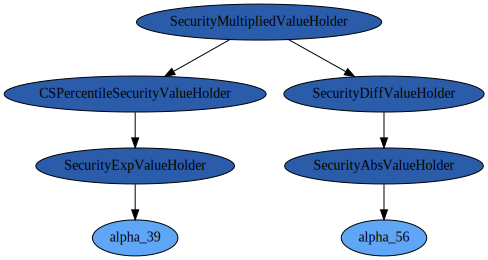

In [14]:
graphviz.Source(draw_program(crossover_program))

## 变异计算

#### 树突变 - 等同于交叉计算

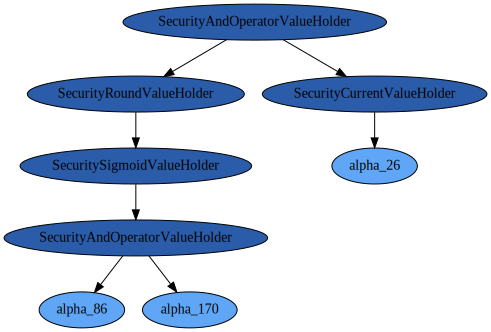

In [22]:
copy_program = program
chicken_program = calcu_program()
start, end = get_subtree(copy_program)
removed = range(start, end)

chicken_start, chicken_end = get_subtree(chicken_program)
chicken_removed = list(set(range(len(chicken_program))) -
                             set(range(chicken_start, chicken_end)))
crossover_program = copy_program[:start] + chicken_program[chicken_start:chicken_end] + copy_program[end:]
graphviz.Source(draw_program(crossover_program))

#### 提升突变

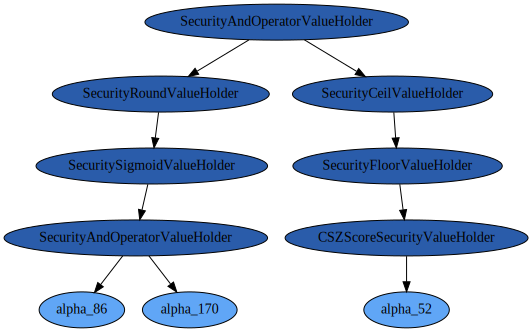

In [16]:
copy_program = program
start, end = get_subtree(copy_program)
subtree = program[start:end]
sub_start, sub_end = get_subtree(subtree)
hoist = subtree[sub_start:sub_end]
hosit_program = copy_program[:start] + hoist + copy_program[end:]
graphviz.Source(draw_program(hosit_program))

#### 节点突变

In [60]:
copy_program = copy(program)
mutate = np.where(np.random.uniform(size=len(copy_program)) < 0.5)[0]
for node in mutate:
    if copy_program[node] in function_sets:
        activy = copy_program[node]['activy']
        #找到参数个数替换
        if activy == 1:
            replace_node = mutated_sets[np.random.randint(0,len(mutated_sets)-1)]
        else:
            replace_node = cross_sets[np.random.randint(0,len(cross_sets)-1)]
        copy_program[node] = replace_node
    else:
        factor = facotr_sets[np.random.randint(0,len(facotr_sets)-1)]
        copy_program[node] = factor

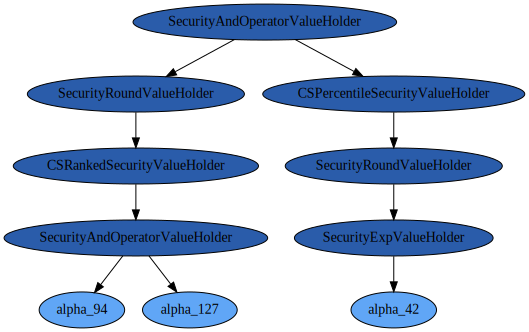

In [61]:
graphviz.Source(draw_program(copy_program))

## 计算因子值

In [10]:
def create_formual(apply_formual):
    function = apply_formual[0]
    formula = function['function'].__name__
    formula +='('
    for i in range(0,function['activy']):
        if i != 0:
            formula += ','
        if apply_formual[i+1] in facotr_sets:
            formula += '\'' + apply_formual[i+1] + '\''
        else:
            formula += apply_formual[i+1]
    formula += ')'
    return formula

In [14]:
apply_stack = []
for node in program:
    if node in function_sets:
        apply_stack.append([node])
    else:
        apply_stack[-1].append(node)
    while len(apply_stack[-1]) == apply_stack[-1][0]['activy'] + 1:
        result = create_formual(apply_stack[-1])
        if len(apply_stack) != 1:
            apply_stack.pop()
            apply_stack[-1].append(result)
        else:
            print(result)
            break

SecuritySignValueHolder(SecurityDividedValueHolder(SecurityEqOperatorValueHolder(SecurityEqOperatorValueHolder('alpha_7','alpha_81'),SecuritySqrtValueHolder('alpha_66')),SecurityNormInvValueHolder(SecurityLtOperatorValueHolder('alpha_88','alpha_8'))))


In [17]:
%%time
rt = eval(result).transform(total_data.set_index(['trade_date']), category_field='code', dropna=False)

/home/kerry/work/workenv/alpha_mind/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


CPU times: user 12.5 s, sys: 152 ms, total: 12.7 s
Wall time: 12.7 s


In [16]:
rt

,transformed,code
trade_date,,
2018-09-18,0.0,10
2018-09-18,0.0,852
2018-09-18,0.0,2019
2018-09-18,0.0,2278
2018-09-18,0.0,2380
2018-09-18,0.0,2468
2018-09-18,0.0,2624
2018-12-03,0.0,300674
2018-09-18,0.0,2850
